# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

## Neural Network Model

Prompt:

```md
give me a tensorflow scaffolding that:
loads test, train, validate csvs from ./data
takes 7 features in a timeseries, with seasonality, across 12 months for 14 years
outputs a signal for an entire year
```

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd



import matplotlib.pyplot as plt


DATA_PATH = "./data"



END_DATE = datetime(2022, 12, 31)

train_df = pd.read_csv(f"{DATA_PATH}/train_data.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv(f"{DATA_PATH}/test_data.csv", index_col=0, parse_dates=True)
test_df = test_df[test_df.index <= END_DATE]



print(f"Shapes: train_df: {train_df.shape} test_df: {test_df.shape}")


test_df.head(12)

Shapes: train_df: (192, 10) test_df: (48, 10)


,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_bln,Population_k,tmin,tavg,tmax
Date,,,,,,,,,,
2019-01-01,0.44,224.76,46.96,10.45,63.06,14.190,502.440833,8.8,11.6,14.4
2019-02-01,0.43,199.54,60.59,11.93,55.98,14.105,504.060000,8.7,12.0,15.3
2019-03-01,0.39,199.28,58.86,16.83,55.91,14.020,504.999167,11.2,14.5,17.7
2019-04-01,0.36,186.04,44.68,17.85,52.20,13.935,505.938333,12.6,15.9,19.1
2019-05-01,0.33,189.43,34.20,21.52,53.15,13.850,506.877500,14.3,18.3,22.3
2019-06-01,0.45,231.40,45.46,22.85,64.92,13.765,507.816667,21.3,26.3,31.4
2019-07-01,0.50,278.55,82.34,23.40,78.15,13.680,508.755833,23.2,27.5,32.6
2019-08-01,0.48,283.84,69.46,21.64,79.64,13.595,509.695000,23.8,28.2,32.5
2019-09-01,0.43,238.35,68.75,18.01,66.87,13.510,510.634167,22.0,25.6,29.1


C:\Users\worker\AppData\Local\Temp\ipykernel_5420\2816281674.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


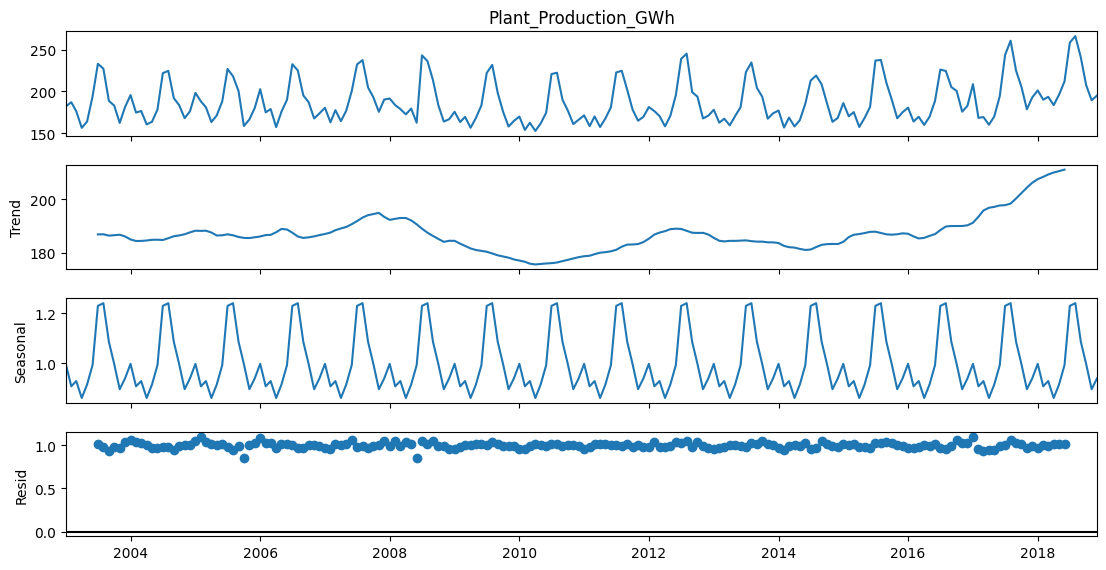

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

FEATURES = [
    "Population_k",
    "tmax",
    "GDP_bln",
]
TARGET = "Plant_Production_GWh"
INDEX = "Date"
TIME_WINDOW = 1
LAGS = 1

decomp_train_df = train_df.copy()
decomp_train_df = decomp_train_df.rename(columns={decomp_train_df.columns[0]: INDEX})
decomp_train_df = decomp_train_df[[INDEX, TARGET]]
adjustment = seasonal_decompose(decomp_train_df[TARGET], model="m", period=12)

fig = adjustment.plot()
fig.set_figheight(6)
fig.set_figwidth(12)
fig.show()

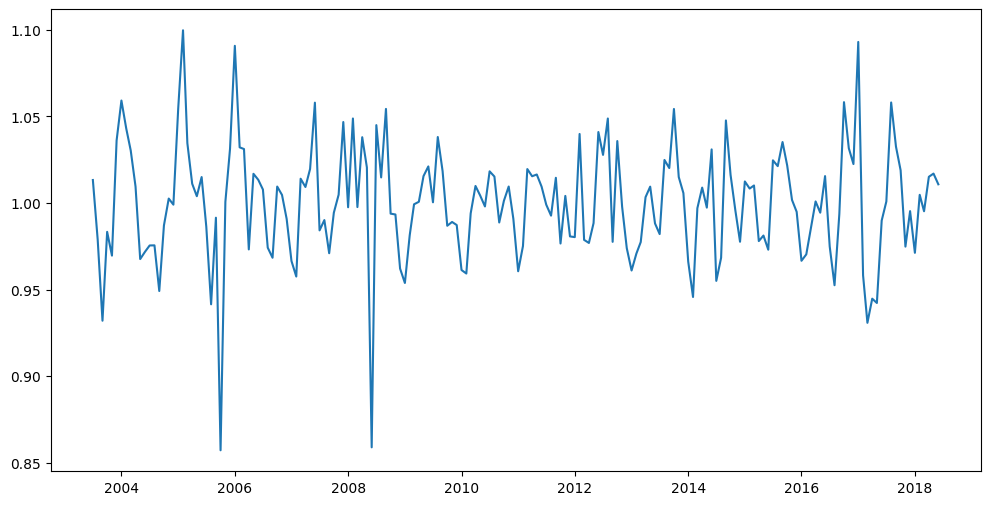

In [3]:
flat_target = decomp_train_df[TARGET] / adjustment.seasonal / adjustment.trend

plt.figure(figsize=(12, 6))
plt.plot(decomp_train_df.index, flat_target)
plt.show()

In [4]:
df_adjustment = pd.DataFrame(
    {
        "Seasonal": adjustment.seasonal,
        "Trend": adjustment.trend,
        "Month": decomp_train_df.index.month,
    }
)

df_adjustment = df_adjustment.groupby("Month").mean()
df_adjustment.reset_index(inplace=True)

# Save weights for future prediction
df_adjustment.to_pickle(f"{DATA_PATH}/seasonal_adjustment.pkl")

df_adjustment

,Month,Seasonal,Trend
0,1,0.998435,186.890389
1,2,0.908536,187.069028
2,3,0.929513,187.320722
3,4,0.861764,187.532194
4,5,0.915589,187.675056
5,6,0.993432,187.788333
6,7,1.230321,186.227000
7,8,1.241180,186.288444
8,9,1.086606,186.344500
9,10,0.997740,186.467417


Givens:
- This is a multivariate TS of pop, temp, demand, industry signals.
- Assume these are asynchronous, therefore noisy

Data DIM:
- 0: Sequences
- 1: Data in sequence
- 2: Features for that datum (AKA channels for COV1D)

In [5]:
def encode_lagged_timeseries(data_df, window=TIME_WINDOW, lag=LAGS):
    sequences, features = list(), list()
    for i in range(window, 0, -1):
        sequences.append(data_df.shift(i))
        features += [("%s(t-%d)" % (col, i)) for col in data_df.columns]

    sequences.append(data_df)
    features += [("%s(t)" % (col)) for col in data_df.columns]

    # the target label - next month if lag is 1
    sequences.append(data_df.shift(-lag))
    features += [("%s(t+%d)" % (col, lag)) for col in data_df.columns]

    ts_df = pd.concat(sequences, axis=1)
    ts_df.columns = features
    ts_df.dropna(inplace=True)

    return ts_df


X = encode_lagged_timeseries(train_df[FEATURES])
y = encode_lagged_timeseries(train_df[[TARGET]])
Xt = encode_lagged_timeseries(test_df[FEATURES])
yt = encode_lagged_timeseries(test_df[[TARGET]])

print(f"Train -> X Shape: {X.shape} y Shape: {y.shape} ")
print(f"Testt -> X Shape: {Xt.shape} y Shape: {yt.shape} ")
X.head(2)

Train -> X Shape: (190, 9) y Shape: (190, 3) 
Testt -> X Shape: (46, 9) y Shape: (46, 3) 


,Population_k(t-1),tmax(t-1),GDP_bln(t-1),Population_k(t),tmax(t),GDP_bln(t),Population_k(t+1),tmax(t+1),GDP_bln(t+1)
Date,,,,,,,,,
2003-02-01,398.58,15.6,4.8200,398.580000,13.0,4.8275,398.804167,15.7,4.8350
2003-03-01,398.58,13.0,4.8275,398.804167,15.7,4.8350,399.028333,18.7,4.8425


In [6]:
X_series = X.values.reshape((X.shape[0], X.shape[1], 1))
Xt_series = Xt.values.reshape((Xt.shape[0], Xt.shape[1], 1))

y_series = y.values.reshape((y.shape[0], y.shape[1], 1))
yt_series = yt.values.reshape((yt.shape[0], yt.shape[1], 1))

print(f"Altered shapes: train: {X_series.shape} test: {Xt_series.shape}")

Altered shapes: train: (190, 9, 1) test: (46, 9, 1)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Input, MaxPooling1D, Dropout, Dense

EPOCHS = 45  # converges around here
BATCH_SIZE = 32
FILTERS = [64, 32, 12]
DROPRATE = 0.18
POOL_SIZE = 2
K_SIZE = 8

model = Sequential(
    [
        Input(shape=(X_series.shape[1], X_series.shape[2])),
        Conv1D(FILTERS[0], kernel_size=K_SIZE, activation="relu"),
        MaxPooling1D(pool_size=POOL_SIZE),  # DIM reduction by 2
        Flatten(),  # Vector dim reduction to 1
        Dense(60, activation="relu"),
        Dropout(DROPRATE),  # this will lessen overfitting.
        Dense(1, activation="linear"),  # Next year 12 predictions.
    ]
)


model.compile(optimizer="adam", loss="mse", run_eagerly=True)
history = model.fit(
    X_series,
    y_series,
    validation_data=(Xt_series, yt_series),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2, 64)             576       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 60)                3900      
                                                                 
 dropout_3 (Dropout)         (None, 60)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 61        
                                                      

2/2 [==============================] - 0s 0s/step - loss: 1379.1946
Largest Error -> train: 23.84376791857125 test: 37.137509072070586


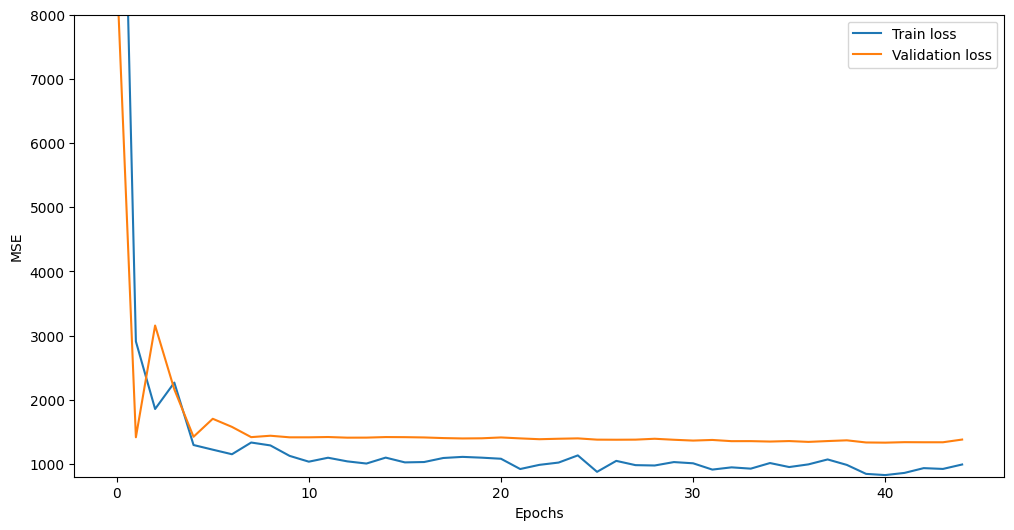

In [16]:
y_pred = model.predict(X_series)
yt_pred = model.predict(Xt_series)

loss = np.sqrt(model.evaluate(X_series, y_series))
t_loss = np.sqrt(model.evaluate(Xt_series, yt_series))

print(f"Largest Error -> train: {loss} test: {t_loss}")

plt.figure(figsize=(12, 6))
plt.ylim(bottom=800, top=8000)
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()  # VGG16

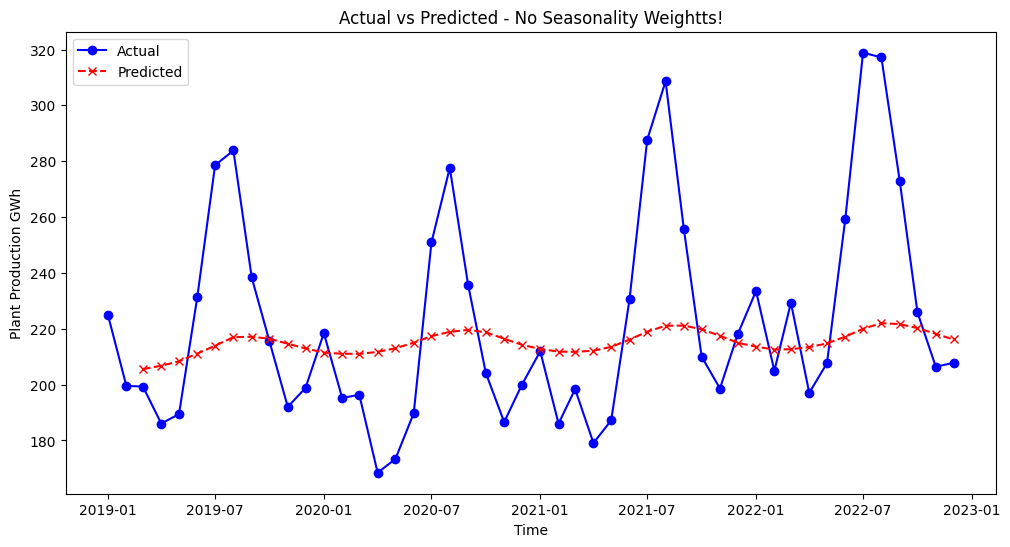

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(test_df[TARGET], label="Actual", color="blue", marker="o")

# we need i full year to predict the next month
plt.plot(
    test_df[TARGET].iloc[TIME_WINDOW + 1 :].index,
    yt_pred,
    label="Predicted",
    color="red",
    linestyle="dashed",
    marker="x",
)

plt.xlabel("Time")
plt.ylabel("Plant Production GWh")
plt.title("Actual vs Predicted - No Seasonality Weightts!")
plt.legend()
plt.show()

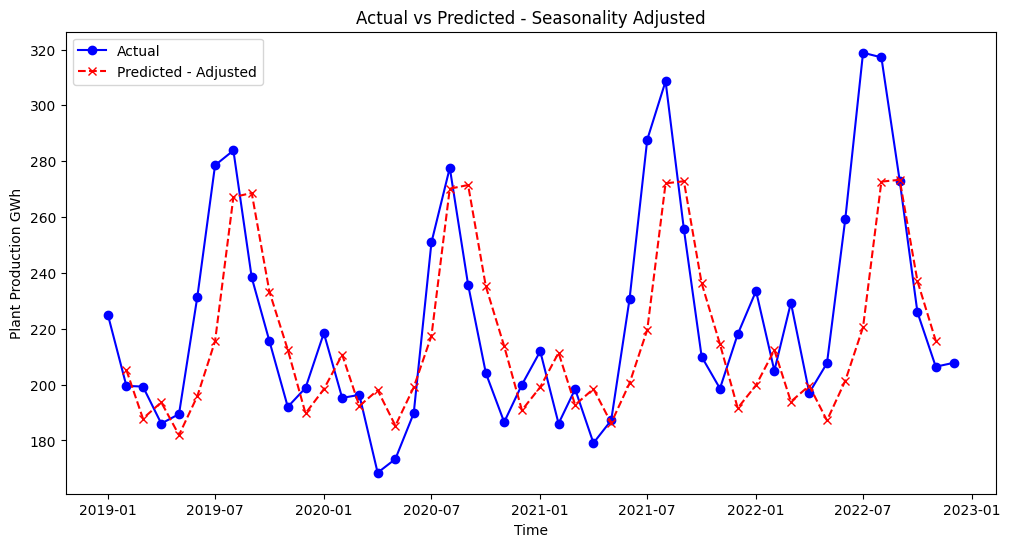

In [18]:
y_pred_adjusted = np.copy(yt_pred)

for i in range(len(y_pred_adjusted)):
    month = (i if i < 12 else i % 12) + 1
    # Making some assumptions here, this is a naive seasonality.
    y_pred_adjusted[i] *= df_adjustment[df_adjustment["Month"] == month][
        "Seasonal"
    ].values[0]


plt.figure(figsize=(12, 6))
plt.plot(test_df[TARGET], label="Actual", color="blue", marker="o")
plt.plot(
    test_df[TARGET].iloc[TIME_WINDOW:-1].index,
    y_pred_adjusted,
    label="Predicted - Adjusted",
    color="red",
    linestyle="dashed",
    marker="x",
)

plt.xlabel("Time")
plt.ylabel("Plant Production GWh")
plt.title("Actual vs Predicted - Seasonality Adjusted")
plt.legend()
plt.show()